In [181]:
import numpy as np
import pandas as pd
import random
import copy

from math import sqrt, log
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.spatial
from haversine import haversine

import warnings
warnings.filterwarnings('ignore')

#### Download datasets

In [182]:
times = pd.read_csv(rf'./files/times v4.csv', sep=',')
lenght = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='TIDS')
income = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='Incomes')

income = income.set_index('TID')
lenght = lenght.set_index('TID')

random.seed(42)

In [183]:
distance_matrix = times.pivot_table(index = 'Origin_tid', columns = 'Destination_tid', values = 'Total_Time')
distance_matrix = distance_matrix.fillna(0)

# Visualisation

In [184]:
def get_divisors(number):
  result = {1, number}
  for divisor in range(2, number // 2  + 1):
    if number % divisor == 0:
        result.add(divisor)

  result = list(sorted(result))
  lenght_list = len(result)//2

  return result[lenght_list-1:lenght_list+1]

In [185]:
def separation_to_squares(df: pd.DataFrame, n_squares: int=4) -> dict:

    '''
        if n_squares is not power of 2, separetion will be separate for bigger different of metrics
    '''
    if n_squares < 0:
        print('Separation number is negative')
        return {}
    
    north = df.longitude.max()
    south = df.longitude.min()
    east = df.latitude.max()
    west = df.latitude.min()

    result = dict()

    '''
        search divisors for separetion of square
    '''
    if n_squares ** .5 == int(n_squares ** .5):
        multiplies = [int(sqrt(n_squares))-1]*2
    else:
        multiplies = get_divisors(n_squares)
        if multiplies[0] == 1:
            print('Primal number!')
            return result

    '''
        determine the position vaertical or horizontal
    '''
    if (north - south) > (east - west):
        position = 'vertical'
    else:
        position = 'horizontal'


    minimal = multiplies[0]+1
    maximal = multiplies[1]+1
    if multiplies[0] != multiplies[1]:
        if (n_squares != 0) and (n_squares & (n_squares-1) == 0):
                if position == 'vertical':
                    result['longitude'] = list(np.linspace(north, south, minimal))
                    result['latitude'] = list(np.linspace(east, west, maximal))
                else:
                    result['longitude'] = list(np.linspace(east, west, maximal))
                    result['latitude'] = list(np.linspace(north, south, minimal))
        else:
            if position == 'vertical':
                result['longitude'] = list(np.linspace(north, south, minimal))
                result['latitude'] = list(np.linspace(east, west, maximal))
            else:
                result['longitude'] = list(np.linspace(east, west, maximal))
                result['latitude'] = list(np.linspace(north, south, minimal))
    else:
        if position == 'vertical':
            result['longitude'] = list(np.linspace(north, south, minimal+1))
            result['latitude'] = list(np.linspace(east, west, maximal+1))
        else:
            result['longitude'] = list(np.linspace(east, west, maximal+1))
            result['latitude'] = list(np.linspace(north, south, minimal+1))

    result['longitude'] = result['longitude'][1:-1]
    result['latitude'] = result['latitude'][1:-1]
    result['side'] = {'north': north, 'south': south, 'east': east, 'west': west}

    return result


In [186]:
def visualisation_of_squares(df: pd.DataFrame, n_squares: int=4) -> dict:
    if n_squares < 0:
        print('Separation number is negative')
        return dict()
    multiplies = get_divisors(n_squares)
    if multiplies[0] == 1 and not (n_squares ** .5 == int(n_squares ** .5)):
        print('Primal number!')
        return dict()
    
    result = separation_to_squares(df, n_squares)

    fig, axes = plt.subplots(figsize=(12, 12))
    axes.scatter(data=df, x='latitude', y='longitude')

    for x in result['latitude']:
        axes.plot(np.array([x, x]), np.array([result['side']['south'], result['side']['north']]), color='red')

    for x in result['longitude']:
        axes.plot(np.array([result['side']['west'], result['side']['east']]), np.array([x, x]), color='red')
        
    axes.set_xlabel('latitude')
    axes.set_ylabel('longitude')

    return result

In [187]:
#visualisation_of_squares(lenght, 9)

#### Math model

In [188]:
model = copy.deepcopy(income)
RUB = 10**6
days = 14
month_day = 30
downtime = 10

In [189]:
tmp = list(income.columns)
model['sum'] = model[tmp].sum(axis=1)
model['mean'] = model[tmp].mean(axis=1)
model['std'] = model[tmp].std(axis=1)
model = model.drop(columns=tmp)

model['day'] = RUB/model['mean']
model['day_with_limit'] = np.where(model.day>=14, 14, model.day)
model['number_trips'] = month_day/model.day_with_limit
model['limit'] = model['day_with_limit'].round(0)
model['quantity'] = 1


model['test'] = model['number_trips'].round()

In [190]:
pivotmodel2 = model.groupby(by='limit')[['quantity']].sum().reset_index()
pivotmodel2['loop'] = pivotmodel2.quantity / pivotmodel2.limit.max()
pivotmodel2['case_loop'] = pivotmodel2.limit.max() / pivotmodel2.limit
pivotmodel2['category'] = np.where(pivotmodel2.loop > 5, 'b', 'a')

In [191]:
model = model.reset_index().merge(pivotmodel2[['limit', 'category']], on='limit', how='left')
model = model.set_index('TID')

#### K-Means Classtering

In [192]:
A_category = lenght.merge(model.query('category == "a"')[['test']], left_index=True, right_index=True, how='inner')
B_category = lenght.merge(model.query('category == "b"')[['test']], left_index=True, right_index=True, how='inner')
df = lenght.merge(model[['mean']], left_index=True, right_index=True, how='inner')

In [193]:
class Clastering():

    def __init__(self, df: pd.DataFrame, case: str, claster_limit: float, figsize: tuple=(5,3)):
        self.df = df
        self.case = case
        self.claster_limit = claster_limit
        self.__k = claster_limit+1
        self.figsize = figsize


    def distance(self, p1, p2):
        return haversine(p1[1:],p2[1:])
    

    def cluster_centroids(self, vals, clusters, k):
        results=[]
        for i in range(k):
            results.append(np.average(vals[clusters == i],weights=np.squeeze(np.asarray(vals[clusters == i][:,[0]])),axis=0))
        return results


    def kmeans(self, vals, k=None, centroids=None, steps=20):
        centroids = vals[np.random.choice(np.arange(len(vals)), k, False)]
        elbow = []
        for _ in range(max(steps, 1)):
            sqdists = scipy.spatial.distance.cdist(centroids, vals, lambda u, v: (self.distance(u,v)**2))
            elbow.append(sqdists)
            clusters = np.argmin(sqdists, axis=0)
            new_centroids = self.cluster_centroids(vals, clusters, k)
            if np.array_equal(new_centroids, centroids):
                break
            centroids = new_centroids
        
        return clusters, centroids, elbow


    def SSE(self) -> dict:
        vals = self.df[[self.case,'latitude','longitude']].values
        sse=[]
        data = {}
        try:
            for k in range(1,self.__k):
                clusters, centroids, elbow=self.kmeans(vals, k)
                sqdist = np.sum((elbow-np.mean(elbow))**2)
                sse.append(sqdist)
                data[k] = {'clusters': clusters, 'centroids': centroids, 'elbow': elbow}

            sse=sorted(sse,reverse=True)
            return {'sse': sse, 'data': data}
        except Exception:
            return self.SSE()

    def define_claster_limit(self, sse: list) -> list[int]:
        return [self.claster_limit, sse[self.claster_limit-1]]
        # for x in sse:
        #     if x <= self.claster_limit:
        #         c.append(sse.index(x)+1)
        #         c.append(x)
        #         return c

    
    def visualisation_claster(self) -> dict:
        df = self.SSE()
        sse = df['sse']
        fig = plt.figure(figsize=(5,3))
        c = self.define_claster_limit(sse)
        x=list(range(1,self.__k))
        labels=x
        plt.plot(x,sse,'r')
        plt.scatter(x,sse,marker='x')
        plt.xticks(x, labels)
        plt.title('Elbow Method')
        plt.xlabel('K')
        plt.ylabel('SSE Distance')
        plt.plot([c[0], c[0]], [0, c[1]], color='green', linestyle='dashed', linewidth=2)  # plotting the arbitrary line from point (25,10) to (65,45).    
        plt.show()
        df['clester_count'] = c[0]
        return df


    def selections(self):
        scce = self.visualisation_claster()
        data = scce['data'][scce['clester_count']]

        self.df['c']=[int(c) for c in data['clusters']]

        lats = [data['centroids'][i][1] for i in range(scce['clester_count'])]
        self.df['clat'] = self.df['c'].map(lambda x: lats[x])

        longs = [data['centroids'][i][2] for i in range(scce['clester_count'])]
        self.df['clong'] = self.df['c'].map(lambda x: longs[x])

        return self.df, scce
    

    @staticmethod
    def plot_clasters(df, k):
        c_lat=list(set(df['clat']))
        c_long=list(set(df['clong']))

        fig, ax = plt.subplots(figsize=(10, 6))
        colors = ['gold', 'cornflowerblue', 'limegreen', 'violet', 'pink', 
                  'brown', 'salmon', 'aqua', 'olive', 'chocolate',
                  'indigo', 'orchid', 'silver', 'peru', 'navu']
        for x in range(k):
            x1=df.query(f'c=={x}')['latitude'].values.tolist()
            y1=df.query(f'c=={x}')['longitude'].values.tolist()
            plt.scatter(y1,x1, color=colors[x])
        plt.scatter(c_long,c_lat,marker='x', color='black')
        plt.show()
        

In [194]:
A_category = Clastering(A_category, 'test', 14)
B_category = Clastering(B_category, 'test', 14)
df = Clastering(df, 'number_trips', 14)

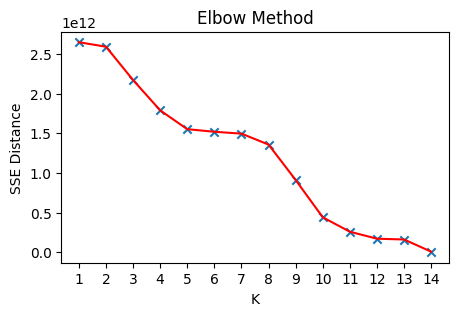

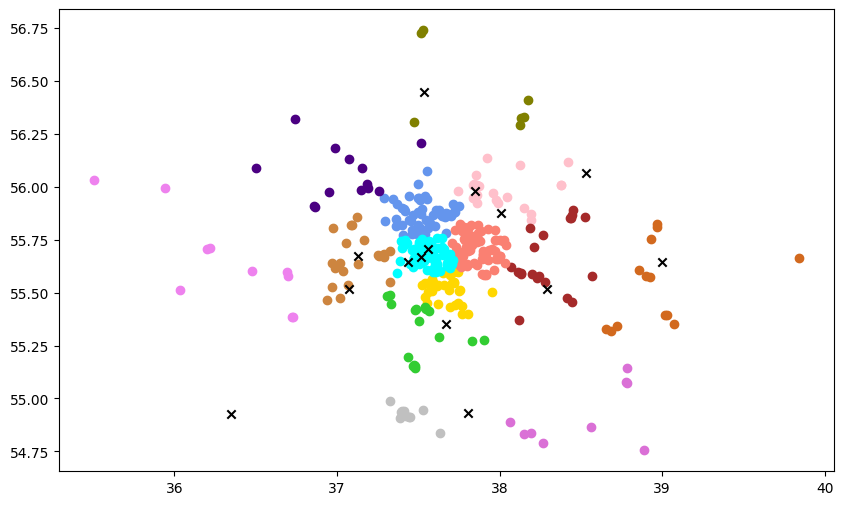

In [195]:
A_category, scce = A_category.selections()
Clastering.plot_clasters(A_category, scce['clester_count'])

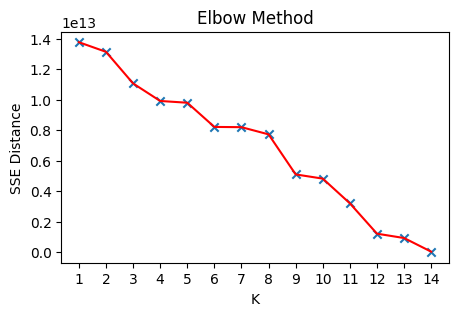

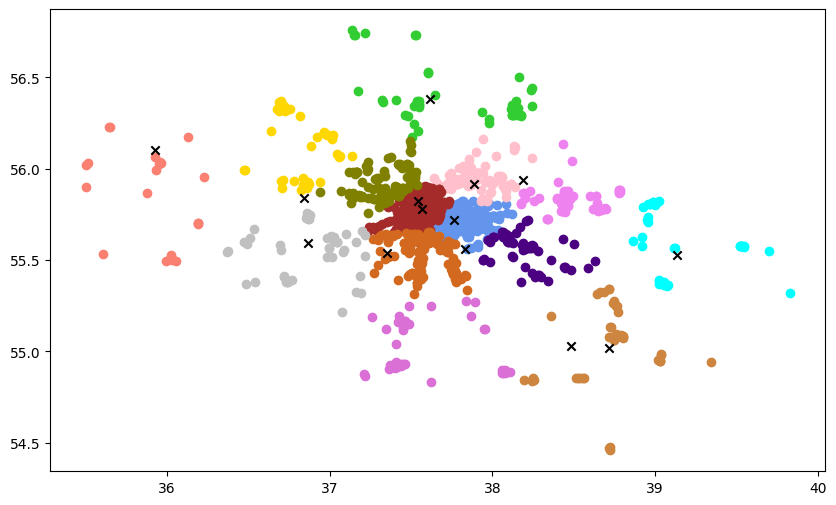

In [196]:
B_category, scce = B_category.selections()
Clastering.plot_clasters(B_category, scce['clester_count'])

#### K-Means Classtering (added)

In [197]:
A_category = A_category.reset_index()
B_category = B_category.reset_index()
model_added = copy.deepcopy(model)


def float_to_int(base: int, x: float) -> int:
    x = str(x).split('.')
    return int(x[0])*base + int(x[1])

In [198]:
A_claster = times.merge(A_category[['TID', 'c']], left_on='Origin_tid', right_on='TID', how='left')
A_claster = A_claster.merge(A_category[['TID', 'c']], left_on='Destination_tid', right_on='TID', how='left')

B_claster = times.merge(B_category[['TID', 'c']], left_on='Origin_tid', right_on='TID', how='left')
B_claster = B_claster.merge(B_category[['TID', 'c']], left_on='Destination_tid', right_on='TID', how='left')

In [199]:
A_claster = A_claster.query('c_x==c_y').drop(columns=['TID_x', 'TID_y', 'c_y']).rename(columns={'c_x': 'cluster'})
B_claster = B_claster.query('c_x==c_y').drop(columns=['TID_x', 'TID_y', 'c_y']).rename(columns={'c_x': 'cluster'})


In [200]:

l = pd.DataFrame({
      'Mean Time': A_claster.query(f'cluster=={x}').Total_Time.mean(), 
      'Number of points': A_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0],
      'Time %': (A_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0]/model.shape[0]) * A_claster.query(f'cluster=={x}').Total_Time.mean(),
      'Number of cluster': x} for x in range(scce['clester_count']))
print(l['Mean Time'].mean())
print(l['Number of points'].sum())
print(l['Number of points'].mean())
l['Total time A'] = l['Mean Time'] * l['Number of points']
l['Total time A / 720'] = l['Total time A'] / 720
print(l['Total time A'].mean())
print(l['Total time A / 720'].mean())
print()
print(l)

35.13431074691185
377
26.928571428571427
725.5568951452487
1.0077179099239564

    Mean Time  Number of points    Time %  Number of cluster  Total time A  \
0   19.668266                32  0.386125                  0    629.384516   
1   20.417838                57  0.713998                  1   1163.816786   
2   33.135294                18  0.365911                  2    596.435294   
3   63.736556                10  0.391022                  3    637.365556   
4   35.061405                21  0.451711                  4    736.289500   
5   45.066474                20  0.552963                  5    901.329474   
6   20.464323                79  0.991829                  6   1616.681538   
7   16.306175                65  0.650246                  7   1059.901406   
8   52.727619                 7  0.226438                  8    369.093333   
9   47.491603                13  0.378767                  9    617.390833   
10  39.743077                13  0.316969                 10   

In [201]:
l = pd.DataFrame({
      'Mean Time': B_claster.query(f'cluster=={x}').Total_Time.mean(), 
      'Number of points': B_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0],
      'Time %': (B_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0]/model.shape[0]) * B_claster.query(f'cluster=={x}').Total_Time.mean(),
      'Number of cluster': x} for x in range(scce['clester_count']))

print(l['Mean Time'].mean())
print(l['Number of points'].sum())
print(l['Number of points'].mean())
l['Total time B'] = l['Mean Time'] * l['Number of points']
l['Total time B / 720'] = l['Total time B'] / 720
print(l['Total time B'].mean())
print(l['Total time B / 720'].mean())
print()
print(l)

35.530790292363704
1253
89.5
2599.9660020709644
3.611063891765228

    Mean Time  Number of points    Time %  Number of cluster  Total time B  \
0   39.789249                44  1.074066                  0   1750.726977   
1   20.525165               221  2.782860                  1   4536.061455   
2   44.792316                55  1.511397                  2   2463.577407   
3   26.036545                73  1.166054                  3   1900.667778   
4   25.243147               117  1.811931                  4   2953.448190   
5   19.578596               214  2.570441                  5   4189.819577   
6   55.265108                26  0.881529                  6   1436.892800   
7   46.584173                40  1.143170                  7   1863.366923   
8   28.837865               116  2.052265                  8   3345.192348   
9   25.018081               138  2.118095                  9   3452.495109   
10  31.191591                65  1.243836                 10   2027.453438 

In [202]:
A_model = model_added.merge(A_claster.drop_duplicates(subset='Origin_tid', keep='first').set_index('Origin_tid')[['Total_Time', 'cluster']], left_index=True, right_index=True, how='inner')
B_model = model_added.merge(B_claster.drop_duplicates(subset='Origin_tid', keep='first').set_index('Origin_tid')[['Total_Time', 'cluster']], left_index=True, right_index=True, how='inner')

In [203]:
A_model['downtime'] = downtime * 60
A_model['Total_Time'] = A_model['Total_Time'].apply(lambda x: float_to_int(100, x))
A_model['Common_Time'] = A_model[['Total_Time', 'downtime']].sum(axis=1)
A_model['Car_per_minute'] = 20000/(12*60)
A_model['Maintenance_cost_one_time'] = A_model['Common_Time']/60 * A_model['Car_per_minute']
A_model['Maintenance_cost_per_month'] = A_model['number_trips'] * A_model['Maintenance_cost_one_time']
A_model['Car_time'] = A_model['number_trips'] * A_model['Common_Time']/60
((A_model.Car_time.sum() / month_day) / (12*60)) * 20000 * 30

1614399.4954710146

In [204]:
B_model['downtime'] = downtime * 60
B_model['Total_Time'] = B_model['Total_Time'].apply(lambda x: float_to_int(100, x))
B_model['Common_Time'] = B_model[['Total_Time', 'downtime']].sum(axis=1)
B_model['Car_per_minute'] = 20000/(12*60)
B_model['Maintenance_cost_one_time'] = B_model['Common_Time']/60 * B_model['Car_per_minute']
B_model['Maintenance_cost_per_month'] = B_model['number_trips'] * B_model['Maintenance_cost_one_time']
B_model['Car_time'] = B_model['number_trips'] * B_model['Common_Time']/60
((B_model.Car_time.sum() / month_day) / (12*60)) * 20000 * 30

3093620.2122368873

In [205]:
B_claster.drop_duplicates(subset='Origin_tid', keep='first')

,Origin_tid,Destination_tid,Total_Time,cluster
83,607066,680312,30.49,11.0
499,606139,634763,14.37,5.0
747,609468,695030,4.76,1.0
825,629520,695030,4.79,1.0
903,698682,695030,5.16,1.0
...,...,...,...,...
1188779,607779,649973,3.30,7.0
1188860,698989,649973,2.56,7.0
1188941,658358,693096,3.64,7.0
1189029,635569,645468,111.03,7.0


### Reesrt of routes

In [242]:
income.columns = pd.to_datetime(income.columns).date
B_income = B_claster.drop_duplicates(subset='Origin_tid', keep='first').rename(columns={'Origin_tid': 'TID'}).set_index('TID')[['cluster']].merge(
    income, left_index=True, right_index=True, how='left'
)
start = B_income.columns[1]

In [243]:
residue = B_income[[start]].reset_index()
residue['Date'] = start
residue['Number_day'] = 0
residue = residue.rename(columns={'TID': 'Id', start: 'Balance_close'})
reestr = pd.DataFrame([], columns=['Id', 'Balance_open', 'Income', 'Outcome', 'Balance_close', 'Date', 'Number_day'])
reestr = pd.concat([reestr, residue]).fillna(0)

In [244]:
if True:
    c = 0
    for x in list(B_income.columns)[2:32]:
        counter = B_income.shape[0]/(14/2)
        nextday = B_income[[x]]
        nextday = nextday.reset_index()
        nextday['Date'] = x
        nextday = nextday.rename(columns={'TID': 'Id', x: 'Income'})

        signal = int(c%14)
        c += 1

        for y in list(nextday.Id):
            
        
            reestr_tmp = reestr.query(f'Id=={y}').tail(1)
            nextday_tmp = nextday.query(f'Id=={y}')

            nextday_tmp['Balance_open'] = reestr_tmp.Balance_close.values[0]


            nextday_tmp['Number_day'] = reestr_tmp.Number_day.values[0]+1
            nextday_tmp['Outcome'] = np.where((nextday_tmp.Balance_open >= 10**6) | 
                                              (nextday_tmp.Number_day == signal), nextday_tmp.Balance_open, 0)
    

            nextday_tmp['Number_day'] = np.where((nextday_tmp.Number_day.values[0] >= 14) | (nextday_tmp.Outcome !=0), 1, nextday_tmp.Number_day)
            nextday_tmp['Balance_close'] = nextday_tmp.Balance_open + nextday_tmp.Income - nextday_tmp.Outcome

            reestr = pd.concat([reestr, nextday_tmp]).fillna(0)

        for y in list(reestr.query('Date == @x and Outcome == 0').sort_values(by='Balance_open', ascending=False).Id):
            if reestr.query(f'Date == @x and Outcome != 0').shape[0] >= counter:
                break

            reestr_tmp = reestr.query(f'Id=={y}').tail(1)
            nextday_tmp = nextday.query(f'Id=={y}')

            nextday_tmp['Balance_open'] = reestr_tmp.Balance_close.values[0]

            nextday_tmp['Outcome'] = np.where(True, nextday_tmp.Balance_open, 0)

            nextday_tmp['Number_day'] = 1
            nextday_tmp['Balance_close'] = nextday_tmp.Balance_open + nextday_tmp.Income - nextday_tmp.Outcome

            reestr = pd.concat([reestr, nextday_tmp]).fillna(0)

    reestr.to_excel(rf'./files/B_reestr_log_std.xlsx', index=False)

In [245]:
pivot = pd.read_excel(rf'./files/B_reestr_log_std.xlsx')
pivot['signal'] = np.where(pivot.Outcome != 0, 1, np.nan)
pivot = pivot.pivot_table(index='Date', values='signal', aggfunc='sum')
pivot.to_excel(rf'./files/B_pivotr_log_std.xlsx')
# pivot

,signal
Date,
2022-08-31,0.0
2022-09-01,179.0
2022-09-02,179.0
2022-09-03,179.0
2022-09-04,179.0
2022-09-05,179.0
2022-09-06,179.0
2022-09-07,179.0
2022-09-08,179.0
